In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

In [2]:
import pathlib

dataset_dir = "/kaggle/input/disease-models/Disease_Models_Dataset/Corn"
data_dir = pathlib.Path(dataset_dir).with_suffix('')

classes = os.listdir(dataset_dir)

In [3]:
# Count the number of images in each class
image_counts = []

for class_name in classes:
    class_dir = data_dir / class_name
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        image_counts.append(num_images)
    else:
        image_counts.append(0)

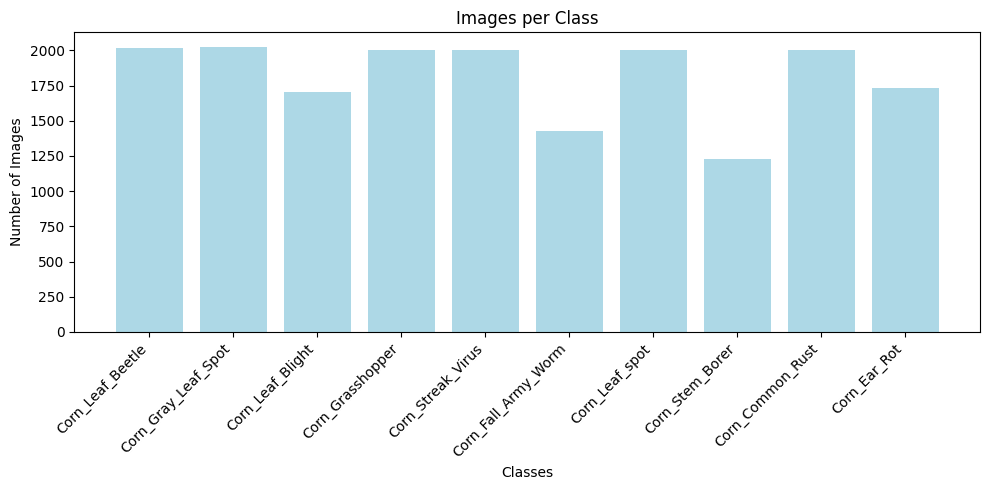

In [6]:
plt.figure(figsize=(10, 5))
plt.bar(classes, image_counts, color='lightblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Images per Class')
plt.xticks(rotation=45, ha='right')  # Rotate class names for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [7]:
batch_size = 14
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
class_names = train_ds.class_names
print(class_names)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [ ]:
num_classes = len(class_names)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [ ]:
model = Sequential([
    # layers.Rescaling(1./255, input_shape=(height, width, channels)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(num_classes, activation='softmax')
])

In [ ]:
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    restore_best_weights=True)

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25,
  callbacks=[early_stopping]
)

In [ ]:
all_images = []
all_labels = []

for images, labels in val_ds:
    all_images.append(images)
    all_labels.append(labels)

all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)

In [ ]:
predictions = model.predict(all_images)

y_pred = np.argmax(predictions, axis=1)
y_true = all_labels

In [ ]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Save the best model as a .keras file
model.save('apple_bell_pepper_model.keras')

In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model('/kaggle/working/test_model.keras')

In [ ]:
img_path = '/kaggle/input/test-image-50/Test Images/TomatoEarlyBlight2.JPG'

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  


predictions = loaded_model.predict(img_array)

score = tf.nn.softmax(predictions[0])

max_index = np.argmax(score)
max_class_name = class_names[max_index]
max_score = score[max_index]

print(f"\nThis image belongs to {max_class_name} with a {int(max_score * 100)}% confidence.",)

In [ ]:
from IPython.display import FileLink 
FileLink('apple_bell_pepper.keras')